In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


def init_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    return (tokenizer, config, model)

In [18]:
import pandas as pd

file_path = "../data/1comments.h5"
df = pd.read_hdf(file_path, key='df')
df.sample(3)

,id,createdAt,userId,userCreatedAt,classYear,universityId,country,universityName,parentId,questionId,comment,review,chapter_explanation_update,question_update,question_explanation_update,qc_explanation_update
4036,6076,2022-01-04 09:46:39.293000+00:00,7166,2021-04-18 22:20:55.628000+00:00,Year 5,2652,United Kingdom,University of Leeds,NaN,6140,bruh she's 13 with a history of gallstones what,False,None,None,None,None
9763,13524,2022-09-30 19:16:45.898743+00:00,3622,2020-12-17 21:56:34.845000+00:00,Year 4,2665,United Kingdom,University of Plymouth,8212.0,4774,"honestly, got to charge this one to the game :(",False,None,None,None,None
9859,13641,2022-10-08 19:13:24.129286+00:00,16741,2022-01-24 20:02:27.888000+00:00,Year 3,2530,United Kingdom,Anglia Ruskin University,12172.0,5612,"Am I going loco, where does it say that?",False,None,None,None,None


In [19]:
from datasets import Dataset

def dataloader(ds: Dataset):
  for item in ds:
    yield item['text']

ds = Dataset.from_dict({'text': df['comment']})

# Tone analysis

Checking the tone of submissions

In [20]:
tone_ckpt = "quesmed/tone"

In [21]:
tone_tokenizer, tone_config, tone_model = init_model(tone_ckpt)


In [22]:
from transformers import pipeline
from tqdm import tqdm

tone_pipe = pipeline("sentiment-analysis", 
  model=tone_model, 
  device=device,
  tokenizer=tone_tokenizer,
  max_length=512, 
  truncation=True
)

tone_labels = ['neutral', 'negative', 'positive']

tone_pipe('Cases of Covid are rising!', top_k=len(tone_labels), batch_size=64)

[{'label': 'neutral', 'score': 0.5109187364578247},
 {'label': 'negative', 'score': 0.4633302688598633},
 {'label': 'positive', 'score': 0.02575104683637619}]

In [23]:
res_emotion = []
for res in tqdm(tone_pipe(dataloader(ds), top_k=len(tone_labels), batch_size=64), total=ds.num_rows):
  res_sorted = sorted(res, key=lambda x: x['label'])
  res_emotion.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_emotion, columns=tone_labels))

100%|██████████| 24912/24912 [02:14<00:00, 185.82it/s]


In [24]:
df['tone'] = df[tone_labels].idxmax(axis=1)

In [25]:
df.to_hdf('../data/tuned/2comments.h5', key='df', mode='w')
# df = pd.read_hdf('../data/tuned/2comments.h5', key='df')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_3569/182183184.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone'],
      dtype='object')]

  df.to_hdf('data/tuned/2comments.h5', key='df', mode='w')


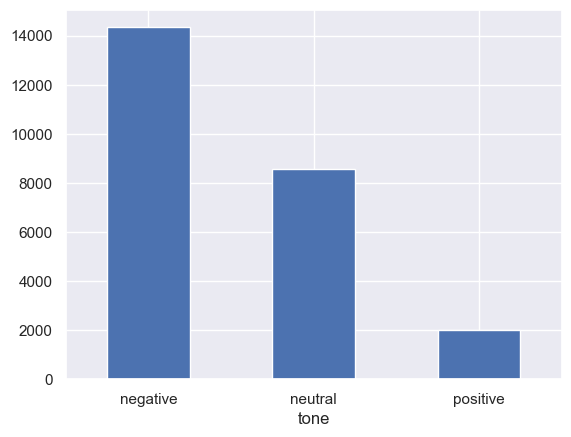

In [26]:
fig, ax = plt.subplots()
ax = df['tone'].value_counts().plot(kind='bar')
plt.xticks(rotation=0, ha='center')
plt.show()

# Emotion Analysis

Checking the emotion of submissions

In [11]:
emotion_chkp = "quesmed/emotion"
emotion_tokenizer, emotion_config, emotion_model = init_model(emotion_chkp)


In [12]:
emotion_pipe = pipeline("zero-shot-classification", 
  model=emotion_model,
  tokenizer=emotion_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

emotion_pipe('Cases of Covid are rising!', 
             top_k=len(emotion_labels), 
             candidate_labels=emotion_labels
             )

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'sequence': 'Cases of Covid are rising!',
 'labels': ['surprise', 'joy', 'anger', 'love', 'sadness', 'fear'],
 'scores': [0.24120871722698212,
  0.16383084654808044,
  0.15383082628250122,
  0.15226863324642181,
  0.14564979076385498,
  0.1432112157344818]}

In [13]:
res_emotion = []
for res in tqdm(emotion_pipe(dataloader(ds), top_k=len(emotion_labels), batch_size=64, candidate_labels=emotion_labels), total=ds.num_rows):
  res_list = []
  for label, score in zip(res['labels'], res['scores']):
    res_list.append({'label': label, 'score': score})
  res_sorted = sorted(res_list, key=lambda x: x['label'])
  res_emotion.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_emotion, columns=emotion_labels))

100%|██████████| 24912/24912 [04:56<00:00, 84.02it/s] 


In [14]:
df['emotion'] = df[emotion_labels].idxmax(axis=1)

In [15]:
df.to_hdf('../data/tuned/3comments.h5', key='df', mode='w')
# df = pd.read_hdf('../data/tuned/3comments.h5', key='df')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_3569/215985439.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone',
       'emotion'],
      dtype='object')]

  df.to_hdf('data/tuned/3comments.h5', key='df', mode='w')


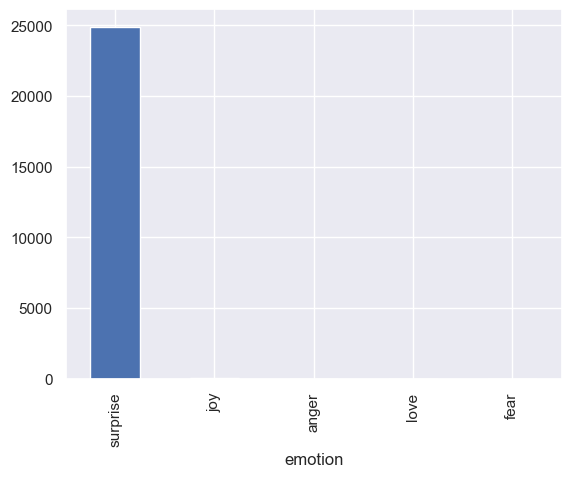

In [16]:
fig, ax = plt.subplots()
ax = df['emotion'].value_counts().plot(kind='bar')

plt.show()

# Zero-shot classification

Classification of submissions based on certain categories

In [64]:
from transformers import AutoModelForSequenceClassification

theme_chkp = "facebook/bart-large-mnli"
theme_tokenizer, _, _ = init_model(theme_chkp)

theme_labels = ['educational', 'giving feedback', 'asking a question', 'insulting', 'supporting']

id2label = {i: k for i, k in enumerate(theme_labels)}
label2id = {k: i for i, k in enumerate(theme_labels)}

theme_model = AutoModelForSequenceClassification.from_pretrained(theme_chkp,
  num_labels=len(theme_labels),
  id2label=id2label,
  label2id=label2id,
  ignore_mismatched_sizes=True
)

theme_pipe = pipeline("zero-shot-classification", 
  model=theme_model,
  tokenizer=theme_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

def theme_analysis(text: str, multi_label=False):
  res = theme_pipe(text, theme_labels, multi_label=multi_label)

  output = {k: 0.0 for k in theme_labels}

  for k, score in zip(res['labels'], res['scores']):
      output[k] = score
  
  return output

theme_analysis("Covid cases are increasing fast!")

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'educational': 0.2142215371131897,
 'giving feedback': 0.1849270462989807,
 'asking a question': 0.27699366211891174,
 'insulting': 0.16431444883346558,
 'supporting': 0.15954318642616272}

In [40]:
for k in theme_labels:
    df[k] = 0.0

In [41]:
for id in tqdm(df.index):
    selftext = df.at[id, 'comment']
    if len(selftext) == 0:
        continue
    output = theme_analysis(selftext)
    for k in theme_labels:
        df.at[id, k] = output[k]

100%|██████████| 22514/22514 [5:54:48<00:00,  1.06it/s]    


In [42]:
df['theme'] = df[theme_labels].idxmax(axis=1)

In [65]:
df.to_hdf('../data/4comments.h5', key='df', mode='w')
# df = pd.read_hdf('../data/4comments.h5', key='df')

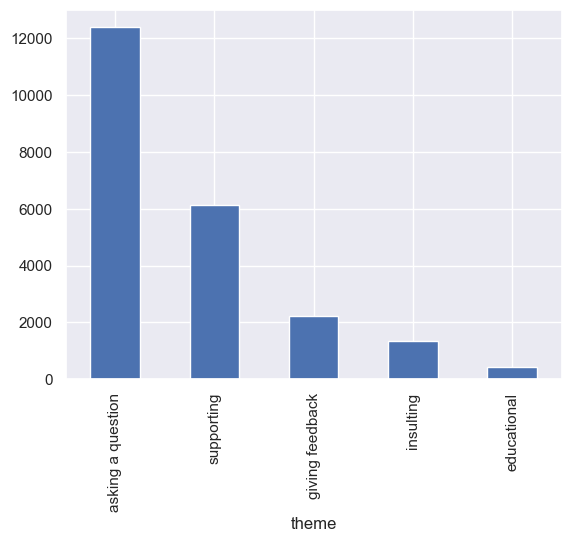

In [66]:
fig, ax = plt.subplots()
ax = df['theme'].value_counts().plot(kind='bar')

plt.show()